In [ ]:
!pip install nilearn
!pip install nibabel

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from nilearn.maskers import nifti_labels_masker
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting as nlp
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from math import ceil


In [2]:
import os
import fnmatch

def buscar_archivos_nii_gz(directorio, cadena):
    archivos_con_cadena = []

    # Recorrer todos los directorios y archivos en el directorio dado
    for raiz, carpetas, archivos in os.walk(directorio):
        for archivo in fnmatch.filter(archivos, '*' + cadena + '*'):
            ruta_completa = os.path.join(raiz, archivo)
            archivos_con_cadena.append(ruta_completa)

    return archivos_con_cadena

# Ejemplo de uso
directorio_a_buscar_control = '/content/drive/MyDrive/neurocon/data/preprocessed/control'
directorio_a_buscar_parkinson = '/content/drive/MyDrive/neurocon/data/preprocessed/parkinson'
cadena_a_buscar = 'brain_mask_applied.nii.gz'
control = buscar_archivos_nii_gz(directorio_a_buscar_control, cadena_a_buscar)
parkinson = buscar_archivos_nii_gz(directorio_a_buscar_parkinson, cadena_a_buscar)


# Imprimir la lista de archivos encontrados
print("Archivos control encontrados:", len(control))
print("Archivos parkinson encontrados:", len(parkinson))

control_train, control_test = train_test_split(control, test_size=0.4, random_state=1)
parkinson_train, parkinson_test = train_test_split(parkinson, test_size=0.4, random_state=1)

# Imprimir la lista de archivos encontrados y divididos

print("Archivos control para entrenamiento:", len(control_train))
print("Archivos control para test:", len(control_test))
print("Archivos parkinson para entrenamiento:", len(parkinson_train))
print("Archivos parkinson para test:", len(parkinson_test))

Archivos control encontrados: 16
Archivos parkinson encontrados: 27
Archivos control para entrenamiento: 9
Archivos control para test: 7
Archivos parkinson para entrenamiento: 16
Archivos parkinson para test: 11


#Si se tiene suficiente memoria ram se puede hacer con:

In [ ]:
# Función para cargar las imágenes
def cargar_imagenes(lista_rutas):
    imagenes = []
    for ruta in lista_rutas:
        img = nib.load(ruta)
        datos = img.get_fdata()
        imagenes.append(datos)
    return imagenes

# Cargar las imágenes para el grupo "parkinson"
imagenes_parkinson = cargar_imagenes(parkinson)
etiquetas_parkinson = np.ones(len(imagenes_parkinson))  # Etiqueta 1 para "parkinson"

# Cargar las imágenes para el grupo "control"
imagenes_control = cargar_imagenes(control)
etiquetas_control = np.zeros(len(imagenes_control))  # Etiqueta 0 para "control"

# Combina los datos y etiquetas de ambos grupos
conjunto_datos = np.concatenate([imagenes_parkinson, imagenes_control])
etiquetas = np.concatenate([etiquetas_parkinson, etiquetas_control])

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    conjunto_datos, etiquetas, test_size=0.2, random_state=42
)

x_train = x_train/255
x_test = x_test/255


In [ ]:
# Generador Keras para cargar y preprocesar imágenes bajo demanda
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, lista_rutas_parkinson, lista_rutas_control, batch_size=4):
        self.lista_rutas = lista_rutas_parkinson + lista_rutas_control
        self.etiquetas = np.concatenate([np.full(len(lista_rutas_parkinson), 1), np.full(len(lista_rutas_control), 0)])
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.lista_rutas) / self.batch_size))

    def __getitem__(self, idx):
        batch_rutas = self.lista_rutas[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_etiquetas = self.etiquetas[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Manejo del final de los datos: vuelve a empezar desde el principio
        if len(batch_rutas) < self.batch_size:
            idx = 0
            batch_rutas = self.lista_rutas[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_etiquetas = self.etiquetas[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_imagenes = [self.cargar_imagen(ruta) for ruta in batch_rutas]
        return np.array(batch_imagenes), np.array(batch_etiquetas)


    def cargar_imagen(self, ruta):
        img = nib.load(ruta)
        datos = img.get_fdata()
        datos = datos / 255  # Normalización (puedes ajustar según necesites)
        return datos

modelo = tf.keras.models.Sequential()

# Capa convolucional 3D 1
modelo.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(189, 233, 197)))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.MaxPooling2D((2, 2), padding= 'same'))
modelo.add(tf.keras.layers.Dropout(0.25))  # Capa de Dropout

# Capa convolucional 3D 2
modelo.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.MaxPooling2D((2, 2), padding= 'same'))
modelo.add(tf.keras.layers.Dropout(0.25))

# Capa convolucional 3D 3
modelo.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.MaxPooling2D((2, 2), padding= 'same'))
modelo.add(tf.keras.layers.Dropout(0.25))

# Capa convolucional 3D 4
modelo.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.MaxPooling2D((2, 2), padding= 'same'))
modelo.add(tf.keras.layers.Dropout(0.25))

# Aplanar los datos para la capa densa
modelo.add(tf.keras.layers.Flatten())

# Capa densa 1
modelo.add(tf.keras.layers.Dense(512, activation='relu'))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Dropout(0.25))

# Capa de salida
modelo.add(tf.keras.layers.Dense(1, activation='softmax'))

# Resumen del modelo
modelo.summary()

# Crear instancias de generadores para "parkinson" y "control"
generador_combinado_train = DataGenerator(parkinson_train, control_train)
generador_combinado_test = DataGenerator(parkinson_test, control_test)

batch_size = 4

step_por_epoch = ceil((len(parkinson_train) + len(control_train)) / batch_size)
validation_steps = ceil((len(parkinson_test) + len(control_test)) /batch_size)
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Compilar el modelo
opt = tf.keras.optimizers.Adamax()

modelo.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history = modelo.fit(generador_combinado_train, steps_per_epoch=step_por_epoch, epochs=20, verbose=1, callbacks=[early_stopping],
                     validation_data=generador_combinado_test, validation_steps=validation_steps)

# Gráficos
fig = plt.figure(figsize=(10, 5))

# Gráfico de Accuracy
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])  # Establecer límites en el eje y de 0 a 100
ax.legend()

# Gráfico de Loss
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

print("Accuracy train",np.mean(history.history['accuracy']))
print("Accuracy de validacion:",np.mean(history.history['val_accuracy']))


#Hacer el testeo

In [11]:
# Función para cargar las imágenes
def cargar_imagenes(lista_rutas):
    imagenes = []
    for ruta in lista_rutas:
        img = nib.load(ruta)
        datos = img.get_fdata() / 255
        imagenes.append(datos)
    return imagenes

# Cargar las imágenes para el grupo "parkinson"
imagenes_parkinson = cargar_imagenes(parkinson_test)
etiquetas_parkinson = np.ones(len(imagenes_parkinson))  # Etiqueta 1 para "parkinson"

# Cargar las imágenes para el grupo "control"
imagenes_control = cargar_imagenes(control_test)
etiquetas_control = np.zeros(len(imagenes_control))  # Etiqueta 0 para "control"

# Combina los datos y etiquetas de ambos grupos
conjunto_datos = np.concatenate([imagenes_parkinson, imagenes_control])
etiquetas = np.concatenate([etiquetas_parkinson, etiquetas_control])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = modelo.predict(conjunto_datos)

# Calcular y mostrar métricas
accuracy = accuracy_score(etiquetas, y_pred)
precision = precision_score(etiquetas, y_pred)
recall = recall_score(etiquetas, y_pred)
f1 = f1_score(etiquetas, y_pred)
conf_matrix = confusion_matrix(etiquetas, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Un modelo usando Conv3D

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 187, 231, 195, 4   112       
                             )                                   
                                                                 
 batch_normalization_5 (Bat  (None, 187, 231, 195, 4   16        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 94, 116, 98, 4)    0         
 g3D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 94, 116, 98, 4)    0         
                                                                 
 conv3d_5 (Conv3D)           (None, 92, 114, 96, 6)    654       
                                                      

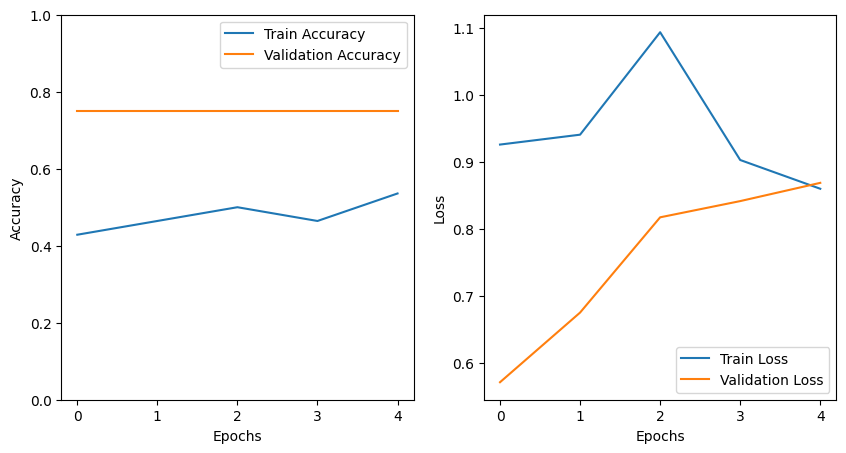

Accuracy train 0.4785714209079742
Accuracy de validación: 0.75


In [4]:
class DataGenerator(Sequence):
    def __init__(self, lista_rutas_parkinson, lista_rutas_control, batch_size=4):
        self.lista_rutas = lista_rutas_parkinson + lista_rutas_control
        self.etiquetas = np.concatenate([np.full(len(lista_rutas_parkinson), 1), np.full(len(lista_rutas_control), 0)])
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.lista_rutas) / self.batch_size))

    def __getitem__(self, idx):
        batch_rutas = self.lista_rutas[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_etiquetas = self.etiquetas[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Manejo del final de los datos: vuelve a empezar desde el principio
        if len(batch_rutas) < self.batch_size:
            idx = 0
            batch_rutas = self.lista_rutas[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_etiquetas = self.etiquetas[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_imagenes = [self.cargar_imagen(ruta) for ruta in batch_rutas]
        return np.array(batch_imagenes), np.array(batch_etiquetas)

    def cargar_imagen(self, ruta):
        img = nib.load(ruta)
        datos = img.get_fdata()
        datos = datos / 255  # Normalización (puedes ajustar según necesites)
        # Añadir una dimensión para convertir a datos de 4D (batch_size, height, width, depth, channels)
        return np.expand_dims(datos, axis=-1)

modelo = tf.keras.models.Sequential()

# Capa convolucional 3D 1
modelo.add(tf.keras.layers.Conv3D(4, (3, 3, 3), activation='relu', input_shape=(189, 233, 197, 1)))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.MaxPooling3D((2, 2, 2), padding='same'))
modelo.add(tf.keras.layers.Dropout(0.25))

# Capa convolucional 3D 2
modelo.add(tf.keras.layers.Conv3D(6, (3, 3, 3), activation='relu'))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.MaxPooling3D((2, 2, 2), padding='same'))
modelo.add(tf.keras.layers.Dropout(0.25))

# Capa convolucional 3D 3
modelo.add(tf.keras.layers.Conv3D(8, (3, 3, 3), activation='relu'))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.MaxPooling3D((2, 2, 2), padding='same'))
modelo.add(tf.keras.layers.Dropout(0.25))

# Capa convolucional 3D 4
modelo.add(tf.keras.layers.Conv3D(12, (3, 3, 3), activation='relu'))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.MaxPooling3D((2, 2, 2), padding='same'))
modelo.add(tf.keras.layers.Dropout(0.25))

# Aplanar los datos para la capa densa
modelo.add(tf.keras.layers.Flatten())

# Capa densa 1
modelo.add(tf.keras.layers.Dense(512, activation='relu'))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Dropout(0.25))

# Capa de salida
modelo.add(tf.keras.layers.Dense(1, activation='softmax'))

# Resumen del modelo
modelo.summary()

# Crear instancias de generadores para "parkinson" y "control"
generador_combinado_train = DataGenerator(parkinson_train, control_train)
generador_combinado_test = DataGenerator(parkinson_test, control_test)

batch_size = 4

step_por_epoch = ceil((len(parkinson_train) + len(control_train)) / batch_size)
validation_steps = ceil((len(parkinson_test) + len(control_test)) / batch_size)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Compilar el modelo
opt = tf.keras.optimizers.Adamax()
modelo.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history = modelo.fit(generador_combinado_train, steps_per_epoch=step_por_epoch, epochs=20, verbose=1, callbacks=[early_stopping],
                     validation_data=generador_combinado_test, validation_steps=validation_steps)

# Gráficos
fig = plt.figure(figsize=(10, 5))

# Gráfico de Accuracy
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])  # Establecer límites en el eje y de 0 a 1
ax.legend()

# Gráfico de Loss
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

print("Accuracy train", np.mean(history.history['accuracy']))
print("Accuracy de validación:", np.mean(history.history['val_accuracy']))



#Hacer testeo para Conv3D

In [5]:
# Función para cargar las imágenes
def cargar_imagenes(lista_rutas):
    imagenes = []
    for ruta in lista_rutas:
        img = nib.load(ruta)
        datos = img.get_fdata() / 255
        imagenes.append(datos)
    return np.expand_dims(imagenes, axis=-1)

# Cargar las imágenes para el grupo "parkinson"
imagenes_parkinson = cargar_imagenes(parkinson_test)
etiquetas_parkinson = np.ones(len(imagenes_parkinson))  # Etiqueta 1 para "parkinson"

# Cargar las imágenes para el grupo "control"
imagenes_control = cargar_imagenes(control_test)
etiquetas_control = np.zeros(len(imagenes_control))  # Etiqueta 0 para "control"

# Combina los datos y etiquetas de ambos grupos
conjunto_datos = np.concatenate([imagenes_parkinson, imagenes_control])
etiquetas = np.concatenate([etiquetas_parkinson, etiquetas_control])

1/1 [==============================] - 1s 754ms/step
Accuracy: 0.6111111111111112
Precision: 0.6111111111111112
Recall: 1.0
F1 Score: 0.7586206896551725
Confusion Matrix:


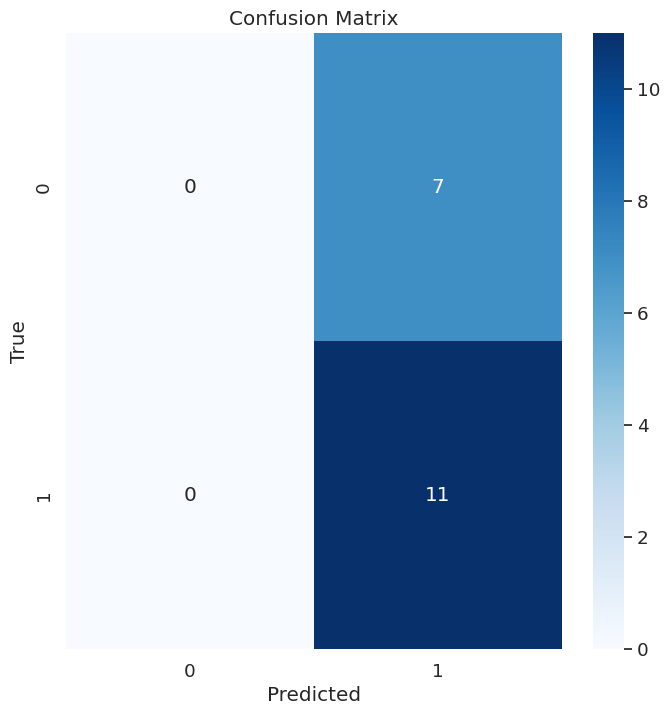

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = modelo.predict(conjunto_datos)
# Calcular y mostrar métricas
accuracy = accuracy_score(etiquetas, y_pred)
precision = precision_score(etiquetas, y_pred)
recall = recall_score(etiquetas, y_pred)
f1 = f1_score(etiquetas, y_pred)
conf_matrix = confusion_matrix(etiquetas, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()